In [2]:
# import the libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import polars as pl

import xgboost as xgb

In [3]:
# read the dataset
data = pl.read_csv("../data/pullreq_with_code.csv", truncate_ragged_lines=True).to_pandas()
data.head()

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_files_open,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,1,0,0,0,0,0,1,79,0,"""eslint"": ""~3.5.0"","
1,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,1,0,0,0,0,0,1,175,0,"""version"": ""0.2.1"","
2,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,9,104,113,110,3,2,24,1,"\t\t} else if !strings.HasPrefix(name, ""*."") {..."
3,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,33,27,60,60,0,2,7,1,\ndef numpy_core_numerictypes_transform():\n ...
4,6,79189935,379,37917551,compsy,vsv,1,91,91.0,1,...,0,26,0,26,11,15,3,13,0,"let!(:responses) { [some_response, another_r..."


In [4]:
data['contrib_gender'].value_counts()

contrib_gender
male      54333
female     5873
Name: count, dtype: int64

In [5]:
# remove accepted requests and remove data where gender is unknown
rejected_data = data.loc[data['merged_or_not'] == 0]
rejected_data = rejected_data.loc[rejected_data['contrib_gender'].notna()]

In [6]:
rejected_data.shape

(8561, 141)

In [7]:
rejected_data['contrib_gender'].value_counts()

contrib_gender
male      7739
female     822
Name: count, dtype: int64

In [8]:
# drop columns that we do not need
rejected_data = rejected_data.drop(['ownername', 'reponame', 'id', 'project_id', 'github_id', 'creator_id'], axis=1)

In [9]:
# characteristics are from the paper (https://yuyue.github.io/res/paper/newPR_MSR2020.pdf)
# prepare characteristics to drop (contributor characteristics, project characteristics, are characteristics that the contributor cannot control)
contributor_characteristics = ['acc_commit_num', 'first_pr', 'core_member', 'same_country', 'same_affiliation', 'contrib_open', 'contrib_cons', 'contrib_extra', 'contrib_agree', 'contrib_neur', 'inte_open', 'inte_cons', 'inte_extra', 'inte_neur', 'inte_agree', 'open_diff', 'cons_diff', 'extra_diff', 'agree_diff', 'neur_diff', 'social_strength', 'account_creation_days', 'prior_review_num', 'first_response_time', 'contrib_country', 'inte_country', 'prior_interaction', 'contrib_affiliation', 'inte_affiliation', 'contrib_first_emo', 'inte_first_emo', 'contrib_follow_integrator']
project_characteristics = ['language', 'project_age', 'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num']
unable_to_control = ['followers', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'pr_comment_num', 'num_issue_comments', 'has_comments', 'has_participants', 'inte_comment', 'has_exchange', 'num_comments_con', 'first_close_minutes', 'num_issue_comments', 'num_participants', 'lifetime_minutes', 'ci_exists',  'reviewer_comment', 'contrib_comment', 'contrib_rate_author'] # features that contributor cannot control

In [10]:
# drop unwanted characteristics
rejected_data.drop(contributor_characteristics, axis=1, inplace=True)
rejected_data.drop(project_characteristics, axis=1, inplace=True)
rejected_data.drop(unable_to_control, axis=1, inplace=True)
rejected_data.drop(['pull_request_id', 'first_closer_id', 'last_closer_id'], axis=1, inplace=True)

In [11]:
rejected_data.shape

(8561, 75)

In [12]:
# Assign smaller class (female) 1
gender_dict = {'male': 0, 'female': 1}

# Use the map function to replace the 'contrib_gender' column
rejected_data['contrib_gender'] = rejected_data['contrib_gender'].map(gender_dict)

In [13]:
rejected_data[rejected_data["contrib_gender"] == 0]

,merged_or_not,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,...,other_files_open,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code
9,0,NaN,6,324,125,1,1,4,6,4,...,0,313,77,390,323,67,3,33,1,/**\n * Test if two BitArrays are identical in...
16,0,NaN,1,2,0,0,0,1,1,1,...,0,2,0,2,1,1,1,0,0,"pref += ""\"";"
49,0,NaN,1,24,22,1,0,3,4,3,...,1,24,22,46,46,0,8,16,1,import org.jgroups.protocols.TP;\nimport java....
55,0,NaN,2,1,0,0,0,2,2,1,...,1,1,0,1,0,1,1,3,0,"- 2.3.1\n - PUPPET_VERSION=""~> 4"""
62,0,NaN,1,0,0,0,0,1,1,0,...,1,0,0,0,0,0,1,31,0,"""phantomjs"": ""~1.9.0"","
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75849,0,NaN,2,26,0,2,0,0,2,1,...,1,26,0,26,26,0,1,0,0,language: java\ninstall: true\nenv:\n- MOZ_HEA...
75854,0,NaN,1,0,0,0,0,1,1,0,...,1,0,0,0,0,0,1,306,0,"""kronos-service-admin"": ""^2.0.5"","
75855,0,NaN,1,9,0,0,0,1,1,1,...,0,9,0,9,9,0,4,28,0,"js_path = ipython_app.js_path,\n ..."
75883,0,NaN,2,12,0,0,0,1,1,1,...,0,6,0,6,4,2,2,1,0,"if (grad_fn) {\n set_history(variables, g..."


In [14]:
rejected_data[rejected_data["contrib_gender"] == 1]

,merged_or_not,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,...,other_files_open,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code
53,0,NaN,3,65,0,0,0,1,1,1,...,0,65,0,65,38,27,3,5,0,"\t""lastUpdated"":""2016-05-12 13:25:00""\n ..."
192,0,NaN,1,21,0,0,0,1,1,1,...,0,0,0,0,0,0,0,62,0,this.temperature = null;\n\tvar temper...
512,0,NaN,2,58,0,0,0,1,1,1,...,0,56,0,56,56,0,1,0,0,\n/**\n * Create a request\n *\n * @param {Re...
691,0,NaN,1,54,52,0,0,2,2,2,...,0,54,52,106,101,5,5,33,1,"@staticmethod\n def from_txt(filename, ..."
729,0,NaN,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,this is a text !
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75529,0,NaN,59,6013,439,4,1,8,13,10,...,0,4398,263,4661,2613,2048,1,147,1,"""""""\n================================\nHierarc..."
75695,0,NaN,1,16,0,0,0,7,7,7,...,0,16,0,16,8,8,8,5,0,private static readonly Uri InternetEx...
75723,0,NaN,4,32,0,0,0,1,1,1,...,0,32,0,32,26,6,2,5,0,"# :api, deprecated in 2.0.0, will be erase..."
75740,0,NaN,1,2,0,0,0,1,1,1,...,0,2,0,2,1,1,1,0,0,"\t\t\t{fbvElement type=""textarea"" multilingual..."


In [15]:
# encode all the columns that are not numerical, and save their label encoders
encoders = { }
for column in rejected_data.select_dtypes(include=['object']).columns:
    le_col = LabelEncoder()
    le_col.fit(rejected_data[column])
    rejected_data[column] = le_col.transform(rejected_data[column])
    encoders[column] = le_col

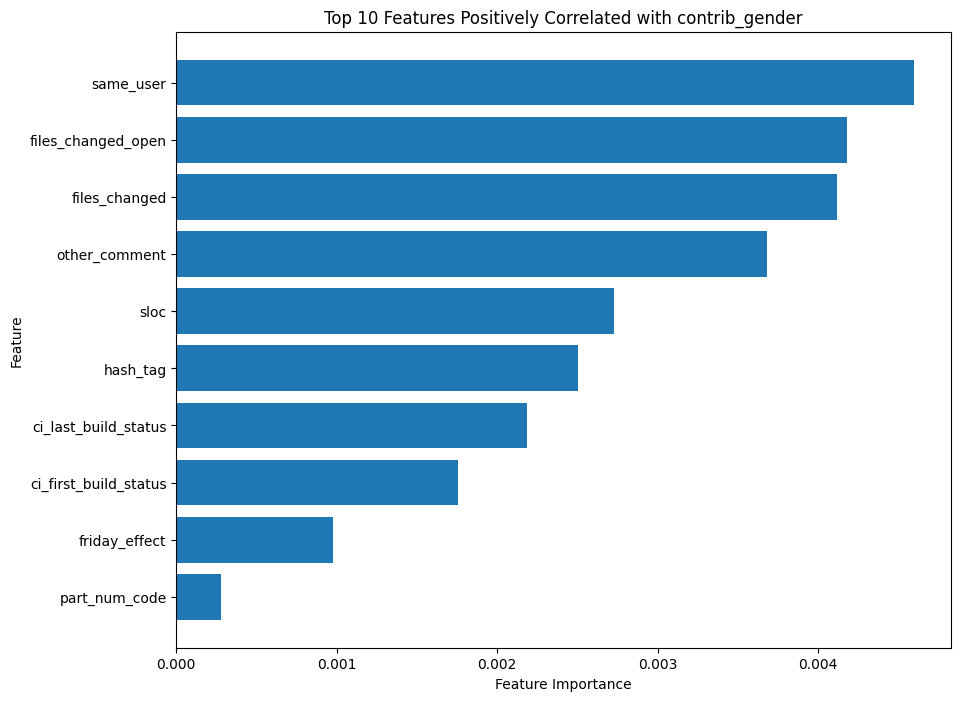

In [16]:
import matplotlib.pyplot as plt

# Calculate correlations using Spearman's rank correlation
correlation_data = rejected_data.drop(['merged_or_not'], axis=1)
corr = correlation_data.corr(method='spearman')
correlation = corr['contrib_gender']

# Sort correlations by value, excluding 'contrib_gender' and negative correlations
sorted_correlations = sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: x[1])

# Get the top 10 features
top_10_features = sorted_correlations[:10]

# Convert the features and their correlations to a DataFrame
df = pd.DataFrame(top_10_features, columns=['Feature', 'Correlation'])

# Sort the DataFrame by correlation
df = df.sort_values('Correlation', ascending=True)

# Plot the correlations
plt.figure(figsize=(10, 8))
plt.barh(df['Feature'], df['Correlation'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Positively Correlated with contrib_gender')
plt.show()

In [17]:
# find correlation to see which features are important
correlation_data = rejected_data.drop(['merged_or_not'], axis=1)

# Use Spearman's rank correlation coefficient instead of Pearson's
corr = correlation_data.corr(method='spearman')

correlation = corr['contrib_gender']
sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: x[1])

[('part_num_code', 0.00027714641934734123),
 ('friday_effect', 0.0009745915834680386),
 ('ci_first_build_status', 0.0017533139134173579),
 ('ci_last_build_status', 0.002184352046224873),
 ('hash_tag', 0.002500546686686368),
 ('sloc', 0.002728684600355504),
 ('other_comment', 0.003683792490046601),
 ('files_changed', 0.004116257057413397),
 ('files_changed_open', 0.004181591921070099),
 ('same_user', 0.0045997118054226386),
 ('reopen_or_not', 0.004701407829616136),
 ('reopen_num', 0.0047422213093494675),
 ('perc_contrib_pos_emo', 0.00475251073308402),
 ('doc_files', 0.007021672954161341),
 ('doc_files_open', 0.007172050707338908),
 ('requester_succ_rate', 0.009221332265451444),
 ('files_deleted_open', 0.011348365808583236),
 ('added_code', 0.01618426089168008),
 ('num_commits_open', 0.016455848190772438),
 ('files_added', 0.019217088435286838),
 ('other_files', 0.019252275602619183),
 ('perc_external_contribs', 0.021030936085338348),
 ('files_deleted', 0.02112685140206983),
 ('num_commi

In [48]:
threshold = 0.02 # moderate relationship or higher
high_correlation = list(filter(lambda x : x[1] >= threshold, sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: x[1])))
high_correlation_feat = list(map(lambda x : x[0], high_correlation))
print(high_correlation_feat)

['perc_external_contribs', 'files_deleted', 'num_commits', 'files_added_open', 'other_files_open', 'team_size']


In [54]:
# get data and clean up data by removing n/a values
USE_CORRELATION = False

if USE_CORRELATION:
    features = high_correlation_feat
    print(features)
else:
    features = rejected_data.columns.tolist()
    # remove the target column
    toremove = ["contrib_gender", "added_code", "mergetime_minutes"]
    for i in toremove:
        features.remove(i)

# features = ['account_creation_days',  'contrib_open',  'part_num_issue',  'perc_neu_emotion',  'num_participants',  'perc_pos_emotion',  'ci_test_passed',  'asserts_per_kloc',  'followers',  'num_issue_comments',  'perc_neg_emotion',  'lifetime_minutes',  'test_inclusion',  'ci_exists',  'acc_commit_num',  'core_member',  'num_comments',  'at_tag',  'pushed_delta',  'part_num_commit',  'first_response_time',  'ci_latency',  'project_age',  'ci_build_num',  'first_pr',  'hash_tag',  'test_churn',  'num_commit_comments',  'comment_conflict',  'prev_pullreqs',  'bug_fix',  'churn_deletion',  'has_comments',  'has_participants',  'reviewer_comment',  'contrib_comment',  'inte_comment',  'has_exchange',  'same_country',  'perc_contrib_neu_emo',  'social_strength',  'agree_diff',  'contrib_rate_author',  'inte_open',  'contrib_follow_integrator',  'extra_diff',  'num_comments_con',  'first_close_minutes',  'perc_inte_pos_emo',  'neur_diff',  'perc_contrib_neg_emo',  'perc_inte_neu_emo',  'cons_diff',  'same_affiliation',  'test_inclusion_open',  'perc_inte_neg_emo',  'num_code_comments_con',  'friday_effect',  'test_churn_open',  'other_comment',  'perc_contrib_pos_emo',  'integrator_availability',  'churn_deletion_open']
rejected_data_cleaned = rejected_data[[*features, 'contrib_gender']].dropna()
X = rejected_data_cleaned[features]
y = rejected_data_cleaned['contrib_gender']

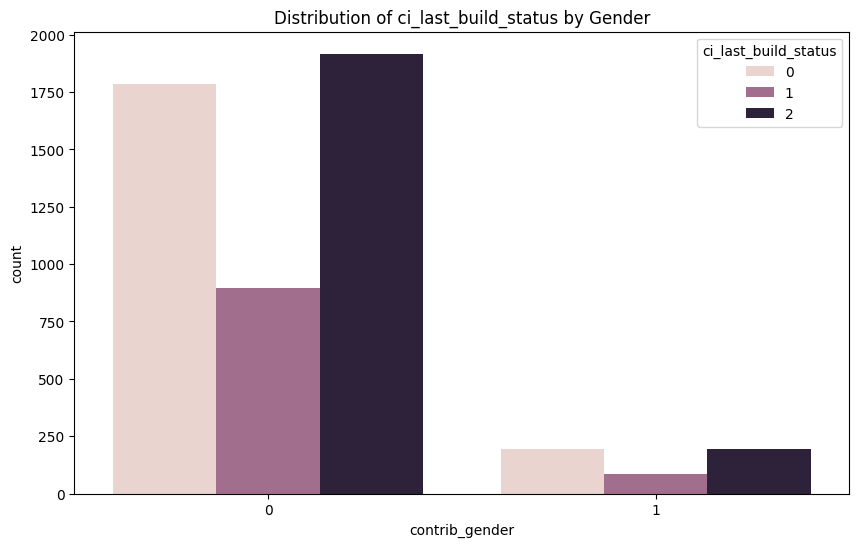

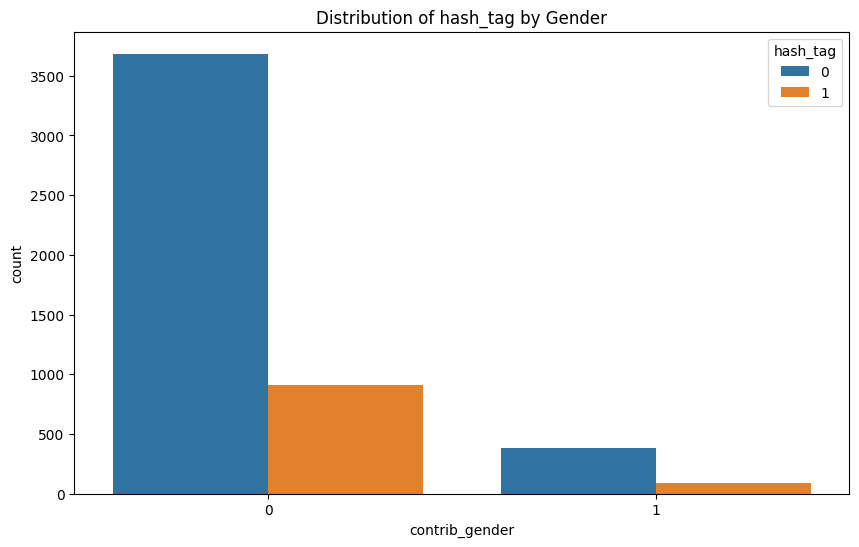

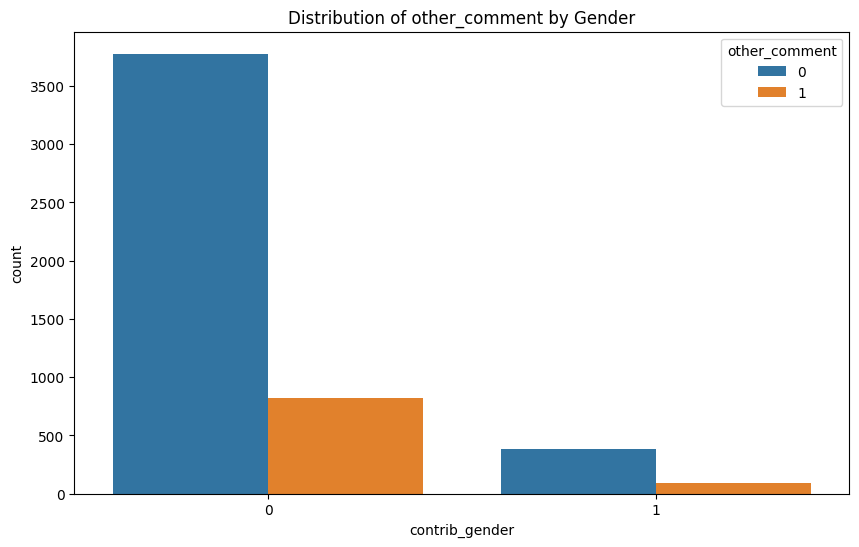

In [55]:
import seaborn as sns
top_features = ['ci_last_build_status', 'hash_tag', 'other_comment']

for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x="contrib_gender", hue=feature, data=rejected_data_cleaned)
    plt.title(f"Distribution of {feature} by Gender")
    plt.show()

In [56]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# split into train test val split
train_ratio = 0.70
test_ratio = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio)

# Create a SMOTE object
smote = SMOTE()

# Fit the SMOTE object to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# train the XGBoost classifier model on the balanced training data
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf = clf.fit(X_train_resampled, y_train_resampled)
clf.score(X_test, y_test)



0.8994743758212878

Feature ranking:
1. feature ci_test_passed (0.11638340353965759)
2. feature ci_last_build_status (0.09245581924915314)
3. feature at_tag (0.07522183656692505)
4. feature ci_first_build_status (0.05456775426864624)
5. feature perc_inte_neu_emo (0.0423225499689579)
6. feature test_inclusion (0.040789972990751266)
7. feature perc_contrib_neu_emo (0.03364478424191475)
8. feature same_user (0.03246922791004181)
9. feature perc_neu_emotion (0.03238125890493393)
10. feature test_inclusion_open (0.030164603143930435)
11. feature part_num_code (0.029962291941046715)
12. feature friday_effect (0.02828986570239067)
13. feature perc_contrib_neg_emo (0.026606915518641472)
14. feature requester_succ_rate (0.023950926959514618)
15. feature ci_failed_perc (0.02243824675679207)
16. feature perc_contrib_pos_emo (0.021492812782526016)
17. feature integrator_availability (0.01286476943641901)
18. feature hash_tag (0.011587959714233875)
19. feature ci_build_num (0.01115348469465971)
20. feature doc_files (

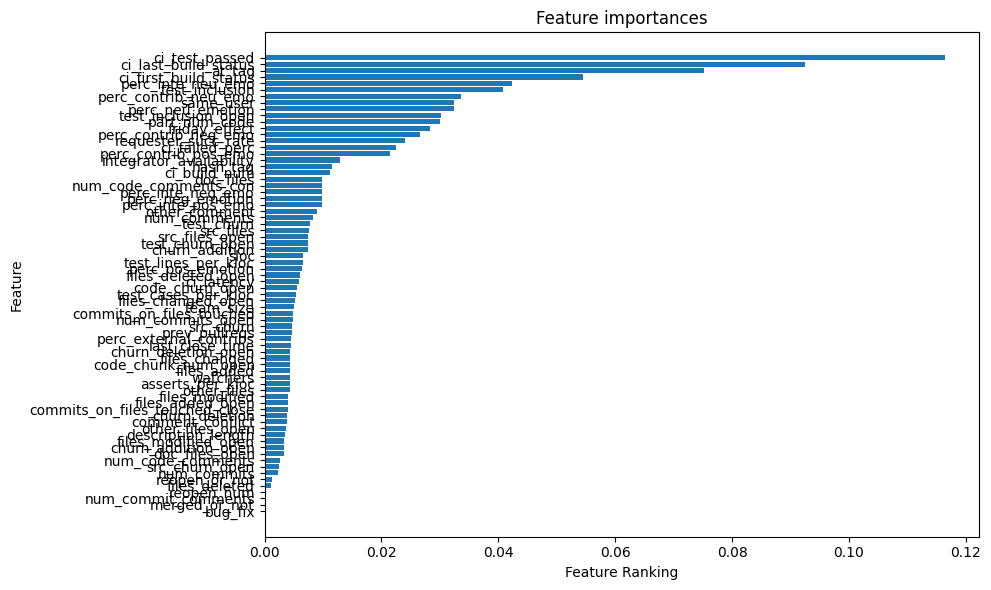

In [57]:
# Get feature importances
importances = clf.feature_importances_

# Map importances to the corresponding feature names and sort them
feature_importances = sorted(zip(importances, X.columns), reverse=True)

# Print the feature ranking
print("Feature ranking:")

for rank, (importance, name) in enumerate(feature_importances, start=1):
    print(f"{rank}. feature {name} ({importance})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.barh([name for importance, name in feature_importances], [importance for importance, name in feature_importances])
plt.ylabel("Feature")
plt.xlabel("Feature Ranking")
plt.gca().invert_yaxis()  # invert the y-axis to have the most important feature at the top
plt.tight_layout()  # improve spacing
plt.show()

In [58]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight

X_array = X.values
y_array = y.values

scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
clf = XGBClassifier(use_label_encoder=False, scale_pos_weight=scale_pos_weight, eval_metric='logloss')

kf = StratifiedKFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    classes_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    clf.fit(X_train, y_train, sample_weight=classes_weights)
    
    predictions = clf.predict(X_test)
    
    print(classification_report(y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       460
           1       0.13      0.17      0.15        47

    accuracy                           0.82       507
   macro avg       0.52      0.53      0.52       507
weighted avg       0.84      0.82      0.83       507

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       460
           1       0.14      0.19      0.16        47

    accuracy                           0.82       507
   macro avg       0.53      0.54      0.53       507
weighted avg       0.84      0.82      0.83       507

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       460
           1       0.17      0.17      0.17        47

    accuracy                           0.84       507
   macro avg       0.54      0.54      0.54       507
weighted avg       0.85      0.84      0.84       507

              preci

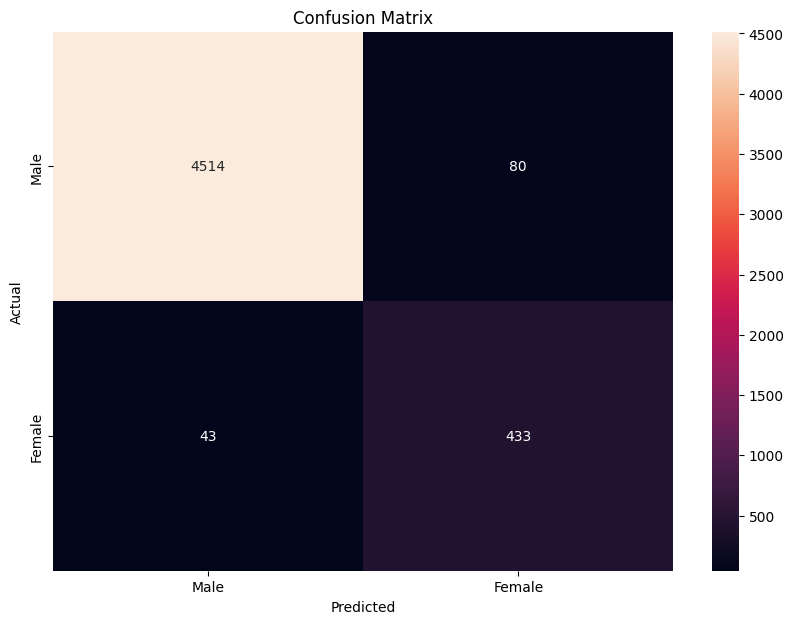

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the model's predictions for the test set
y_pred = clf.predict(X)

# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Replace the labels
labels = ['Male', 'Female']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)

plt.show()